In [1]:
import torch
import torch.nn as nn

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "gpt_model_name": "",
    "gpt_num_params": ""
}

In [3]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
NEW_CONFIG.update({"gpt_model_name": model_name, "gpt_num_params": "124M" })


from classes.model import GPTModel

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [4]:
gpt.load_weights_gpt()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [5]:
# freeze the parameters
for param in gpt.parameters():
    param.requires_grad = False

In [6]:
# replacing the head with a classification one
torch.manual_seed(123)

num_classes = 2
gpt.output_layer = nn.Linear(NEW_CONFIG["emb_dim"], num_classes)

In [7]:
# unfreeze the last n transformer blocks for retrainning
for param in gpt.final_norm.parameters():
    param.requires_grad = True

n_retrain_transformers = 2
for param in gpt.trf_blocks[-n_retrain_transformers].parameters():
    param.requires_grad = True

In [8]:
import tiktoken

tokenizer=tiktoken.get_encoding("gpt2")

In [9]:
text = "Do you have time?"
input = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
input = torch.tensor(input).unsqueeze(0)

with torch.no_grad():
    logits = gpt(input)[:, -1, :]

label = torch.argmax(logits).item() # gives an integer result for the label
label

1

In [10]:
# Data preparation
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path) 

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [45]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("./sms_spam_collection/train.csv", index=None)
validation_df.to_csv("./sms_spam_collection/validation.csv", index=None)
test_df.to_csv("./sms_spam_collection/test.csv", index=None)

Label
ham     747
spam    747
Name: count, dtype: int64


In [46]:
from classes.dataloader import SpamDataset

train_dataset = SpamDataset(
    csv_file="./sms_spam_collection/train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

val_dataset = SpamDataset(
    csv_file="./sms_spam_collection/validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="./sms_spam_collection/test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

# create dataloaders for each dataset
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

120


In [15]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()

    correct_predictions, num_predictions = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break

        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        with torch.no_grad():
            logits = model(input_batch)[:, -1, :]

        predicted_labels = torch.argmax(logits, dim=-1)

        num_predictions += predicted_labels.shape[0]
        correct_predictions += (predicted_labels == target_batch).sum()

    return correct_predictions / num_predictions


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    return nn.functional.cross_entropy(logits, target_batch)

def calc_loss_loader(data_loader, model, device, num_batches=None):
    model.eval()

    loss = 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break

        loss += calc_loss_batch(input_batch, target_batch, model, device)

    return loss / num_batches


In [16]:
device = torch.device("cpu")
gpt.to(device)

torch.manual_seed(123)
 
train_accuracy = calc_accuracy_loader(train_loader, gpt, device, num_batches=10)
print(train_accuracy)

train_loss = calc_loss_loader(train_loader, gpt, device, num_batches=10)
print(train_loss)

tensor(0.4625)
tensor(2.7660, grad_fn=<DivBackward0>)


## Finetunning the gpt model

In [22]:
def train_model_classifier_simple(
    model, train_loader, valid_loader, optimizer, device, 
    num_epochs, eval_freq, eval_iter):

    train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
    examples_seen, global_step = 0, -1

    # main loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # resets the gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            examples_seen += input_batch.shape[0]
            global_step += 1

            # eval step
            if global_step % eval_freq == 0:
                train_loss, valid_loss = evaluate_model(model, train_loader, valid_loader, device, eval_iter)
                
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)

                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss: {train_loss:.3f}, Valid loss: {valid_loss:.3f}")
                
        tr_acc = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        vl_acc = calc_accuracy_loader(valid_loader, model, device, num_batches=eval_iter)
        train_acc.append(tr_acc)
        valid_acc.append(vl_acc)  
        print(f"Training Accuracy: {tr_acc*100:02f}%")
        print(f"Validation Accuracy: {vl_acc*100:02f}%")       

    return train_losses, valid_losses, train_acc, valid_acc, examples_seen


def evaluate_model(model, train_loader, valid_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        valid_loss = calc_loss_loader(valid_loader, model, device, num_batches=eval_iter)
    
    model.train()
    return train_loss, valid_loss

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

In [28]:
# Training time!!
torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5 
train_losses, valid_losses, train_acc, valid_acc, examples_seen = train_model_classifier_simple(gpt, train_loader, val_loader, optimizer, device, num_epochs, eval_freq=50, eval_iter=5)

Epoch 1 (Step 000000): Train loss: 0.490, Valid loss: 0.509
Epoch 1 (Step 000050): Train loss: 0.573, Valid loss: 0.477
Epoch 1 (Step 000100): Train loss: 0.591, Valid loss: 0.494
Training Accuracy: 77.500000%
Validation Accuracy: 82.500000%
Epoch 2 (Step 000150): Train loss: 0.384, Valid loss: 0.392
Epoch 2 (Step 000200): Train loss: 0.401, Valid loss: 0.379
Epoch 2 (Step 000250): Train loss: 0.433, Valid loss: 0.337
Training Accuracy: 90.000000%
Validation Accuracy: 77.500000%
Epoch 3 (Step 000300): Train loss: 0.161, Valid loss: 0.308
Epoch 3 (Step 000350): Train loss: 0.115, Valid loss: 0.168
Training Accuracy: 90.000000%
Validation Accuracy: 90.000000%
Epoch 4 (Step 000400): Train loss: 0.254, Valid loss: 0.198
Epoch 4 (Step 000450): Train loss: 0.026, Valid loss: 0.085
Epoch 4 (Step 000500): Train loss: 0.036, Valid loss: 0.068
Training Accuracy: 92.500000%
Validation Accuracy: 97.500000%
Epoch 5 (Step 000550): Train loss: 0.068, Valid loss: 0.071
Epoch 5 (Step 000600): Train los

In [29]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

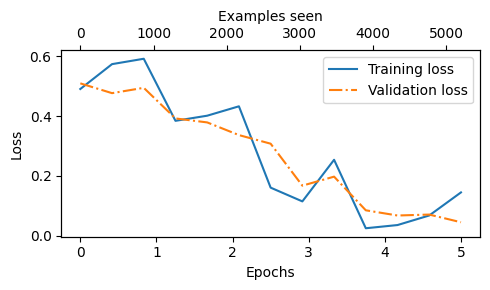

In [30]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, valid_losses)

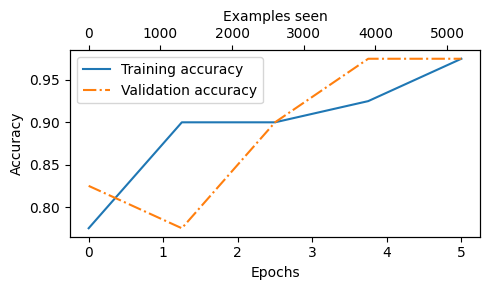

In [31]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_acc))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_acc))

plot_values(epochs_tensor, examples_seen_tensor, train_acc, valid_acc, label="accuracy")

In [37]:
def classify_text(text, model, tokenizer, device, max_length=None, pad_token_id=50256): # pad token is the special end-of-text

    input_tks = tokenizer.encode(text)
    supported_context_lenght = model.position_emb.weight.shape[0]
    max_length = min(max_length, supported_context_lenght)

    # make sure the text is equal or smaller than the model's context lenght
    input_tks = input_tks[:max_length]
    input_tks += [pad_token_id] * (max_length - len(input_tks)) 

    # convert to tensor
    input_tks = torch.tensor(input_tks, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tks)[:, -1, :]

    pred_label = torch.argmax(logits, dim=-1).item()

    return "Spam" if pred_label == 1 else "Not Spam"


In [41]:
# testing the classifier

text = "You have been specially selected to get a 1000 dollars reward!"

res = classify_text(text, gpt, tokenizer=tokenizer, device=device, max_length=train_dataset.max_length)
print(f"The msg: '{text}' is {res}")

text = "Hello there!"

res = classify_text(text, gpt, tokenizer=tokenizer, device=device, max_length=train_dataset.max_length)
print(f"The msg: '{text}' is {res}")

The msg: 'You have been specially selected to get a 1000 dollars reward!' is Spam
The msg: 'Hello there!' is Not Spam


In [43]:
# save the current model
torch.save(gpt.state_dict(), "./weights/text_classifier.pth")